# Demonstration code for "Building a complete RL system" lecture

## Introduction
This code demonstrates our implementation of SARSA for a deterministic FrozenLake task and serves as additional information to go alongside the "Building a complete Rl system" lecture.
The lecture is delivered as part of the [Reinforcement Learning (2020) course](http://www.drps.ed.ac.uk/19-20/dpt/cxinfr11010.html) at the University of Edinburgh.

## Environment: FrozenLake ... but less frozen
Let's first define our deterministic FrozenLake environment. Usually, ice is pretty slippery ... but we prefer it stable. Hence, we remove any slipping and stochasticity and comfortably solve the newly created, deterministic task.

In [1]:
from gym.envs.registration import register
import numpy as np

# register non-slippery/ deterministic FrozenLake environment
register(
    id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
)

## Human Interface
In order to get familiar with the task, we first create an interface such that a human player can play the game. In the end, playing is fun! And it helps us to understand the task at hand. So let's go ...

In [2]:
def str_to_action(act: str) -> int:
    """
    Input transferred to action id (for FrozenLake)

    :param act (int): received input
    :return (int): action id for FrozenLake (and -1 for ESC)
    """
    if act == "A":
        return 0
    elif act == "S":
        return 1
    elif act == "D":
        return 2
    elif act == "W":
        return 3
    elif act == "STOP":
        return -1
    else:
        raise ValueError(f"Unknown input {act}!")
        
def get_input():
    act = input("Choose action [WASD | STOP]")
    if act == "STOP":
        return -1
    else:
        return str_to_action(act)

In [3]:
import gym

def human_player(env: gym.Env):
    """
    Play FrozenLake as a human player with WASD keys
    """
    print("Use WASD to move in the environment and end game with ESC or keyboard interrupt (Ctrl-C)")
    env.reset()
    env.render()

    while True:
        act = get_input()
        
        if act == -1:
            return
        _, rew, done, _ = env.step(act)
        env.render()
        if done:
            if rew == 1:
                print("EPISODE FINISHED - SOLVED")
            else:
                print("EPISODE FINISHED - FAILED")
            env.reset()
            env.render()
    return

In [4]:
env = gym.make('FrozenLakeNotSlippery-v0')
human_player(env)
env.close()

Use WASD to move in the environment and end game with ESC or keyboard interrupt (Ctrl-C)

SFFF
FHFH
FFFH
HFFG
Choose action [WASD | STOP]STOP


## SARSA Agent
Now after understanding the task of FrozenLake, let's implement an agent for the on-policy TD control algorithm, also called SARSA. If you need a revision, have a look at [lecture 6  on Temporal Difference Learning](https://www.learn.ed.ac.uk/bbcswebdav/pid-4067850-dt-content-rid-11604420_1/xid-11604420_1) (Slides 15 - 17) or take a look at [section 6.4 in the RL book](http://www.incompleteideas.net/book/RLbook2018.pdf##page=153) on the SARSA method.

In [5]:
from abc import ABC
from collections import defaultdict
import random
from typing import DefaultDict


class SARSA(ABC):
    """Base class for SARSA agent

    :attr n_acts (int): number of actions
    :attr gamma (float): discount factor gamma
    :attr epsilon (float): epsilon hyperparameter for epsilon-greedy policy
    :attr alpha (float): learning rate alpha for updates
    :attr q_table (DefaultDict): table for Q-values mapping (OBS, ACT) pairs of observations
        and actions to respective Q-values
    """

    def __init__(
            self,
            num_acts: int,
            gamma: float,
            epsilon: float = 0.9,
            alpha: float = 0.1
        ):
        """Constructor for SARSA agent

        Initializes basic variables of the agent namely the epsilon, learning rate and discount
        rate.

        :param num_acts (int): number of possible actions
        :param gamma (float): discount factor (gamma)
        :param epsilon (float): initial epsilon for epsilon-greedy action selection
        :param alpha (float): learning rate alpha
        """
        self.n_acts: int = num_acts
        self.gamma: float = gamma
        self.epsilon: float = epsilon
        self.alpha: float = alpha

        self.q_table: DefaultDict = defaultdict(lambda: 0)

    def act(self, obs: np.ndarray) -> int:
        """Epsilon-greedy action selection 

        :param obs (np.ndarray of float with dim (observation size)):
            received observation representing the current environmental state
        :return (int): index of selected action
        """
        act_vals = [self.q_table[(obs, act)] for act in range(self.n_acts)]
        max_val = max(act_vals)
        max_acts = [idx for idx, act_val in enumerate(act_vals) if act_val == max_val]

        if random.random() < self.epsilon:
            return random.randint(0, self.n_acts - 1)
        else:
            return random.choice(max_acts)

    def learn(
            self,
            obs: np.ndarray,
            action: int,
            reward: float,
            n_obs: np.ndarray,
            n_action: int,
            done: bool
        ) -> float:
        """Updates the Q-table based on agent experience

        :param obs (np.ndarray of float with dim (observation size)):
            received observation representing the current environmental state
        :param action (int): index of applied action
        :param reward (float): received reward
        :param n_obs (np.ndarray of float with dim (observation size)):
            received observation representing the next environmental state
        :param done (bool): flag indicating whether a terminal state has been reached
        :return (float): updated Q-value for current observation-action pair
        """
        target_value = reward + self.gamma * (1 - done) * self.q_table[(n_obs, n_action)]
        self.q_table[(obs, action)] += self.alpha * (
            target_value - self.q_table[(obs, action)]
        )
        return self.q_table[(obs, action)]

    def schedule_hyperparameters(self, timestep: int, max_timestep: int):
        """Updates the hyperparameters

        This function is called before every episode and allows you to schedule your
        hyperparameters.

        :param timestep (int): current timestep at the beginning of the episode
        :param max_timestep (int): maximum timesteps that the training loop will run for
        """
        self.epsilon = 1.0-(min(1.0, timestep/(0.07*max_timestep)))*0.95

## Evaluation Tools
Besides learning Q-values to solve FrozenLake, we would like to observe the progress during our evaluation and visualise our final, learned policy. For this purpose, we implement different visualisation tools to look at our results.

### Text visualisation
First, we implement visualisation of our final policy and print the Q-values obtained during learning.

In [6]:
# visualisation tools for final Q-tables
def visualise_q_table(q_table):
    """
    Print q_table in human-readable format

    :param q_table (Dict): q_table in form of a dict mapping (observation, action) pairs to
        q-values
    """
    for key in sorted(q_table.keys()):
        obs, act = key
        act_name = act_to_str(act)
        q_value = q_table[key]
        print(f"Pos={obs}\tAct={act_name}\t->\t{q_value}")

def act_to_str(act: int):
    if act == 0:
        return "L"
    elif act == 1:
        return "D"
    elif act == 2:
        return "R"
    elif act == 3:
        return "U"
    else:
        raise ValueError("Invalid action value")
        
def visualise_policy(q_table):
    """
    Given q_table print greedy policy for each FrozenLake position

    :param q_table (Dict): q_table in form of a dict mapping (observation, action) pairs to
        q-values
    """
    # extract best acts
    act_table = np.zeros((4,4))
    str_table = []
    for row in range(4):
        str_table.append("")
        for col in range(4):
            pos = row * 4 + col
            max_q = None
            max_a = None
            for a in range(4):
                q = q_table[(pos, a)]
                if max_q is None or q > max_q:
                    max_q = q
                    max_a = a
            act_table[row, col] = max_a
            str_table[row] += act_to_str(max_a)
    
    # print best actions in human_readable format
    print("\nAction selection table:")
    for row_str in str_table:
        print(row_str)
    print()

### Plot visualisation
Now, we implement visualisation of our training progress by generating plots showing the mean rewards obtained during evaluations. Besides rewards, we also want to visualise the $\epsilon$-decay to make sure, this exploration parameter decays nicely as expected.

It is good practise to not just visualise actual rewards obtained during training, but also plot standard deviations of rewards obtained over multiple training runs. This way, we can not just observe the actual performance of our RL algorithm, but keep track of its variance. An algorithm that performs great when we get lucky, but is vary variant might not be that great after all!
Don't fall in the pitfall of "feeling safe" whenever your algorithm performs well in a singular evaluation run!

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("seaborn-darkgrid")
plt.rcParams.update({"font.size": 15})

def plot_timesteps(
        values: np.ndarray,
        eval_freq: int,
        title: str,
        xlabel: str,
        ylabel: str,
        legend_name: str,
    ):
    """
    Plot values with respect to timesteps

    :param values (np.ndarray): numpy array of values to plot as y-values
    :param eval_freq (int): number of training iterations after which an evaluation is done
    :param title (str): name of algorithm
    :param xlabel (str): label of x-axis
    :param ylabel (str): label of y-axis
    :param legend_name (str): name of algorithm
    """
    plt.figure()
    plt.title(title)
    
    x_values = eval_freq + np.arange(len(values)) * eval_freq

    # plot means with respective standard deviation as shading
    plt.plot(x_values, values, label=f"{legend_name}")

    # set legend and axis-labels
    plt.legend(loc="best")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout(pad=0.3)


def plot_timesteps_shaded(
        means: np.ndarray,
        stds: np.ndarray,
        eval_freq: int,
        title: str,
        xlabel: str,
        ylabel: str,
        legend_name: str,
    ):
    """
    Plot mean and std-shading for values with respect to timesteps

    :param means (np.ndarray): numpy array of mean values to plot as y-values
    :param stds (np.ndarray): numpy array of standard deviations to plot as y-value shading
    :param eval_freq (int): number of training iterations after which an evaluation is done
    :param title (str): name of algorithm
    :param xlabel (str): label of x-axis
    :param ylabel (str): label of y-axis
    :param legend_name (str): name of algorithm
    """
    plt.figure()
    plt.title(title)

    x_values = eval_freq + np.arange(len(means)) * eval_freq

    # plot means with respective standard deviation as shading
    plt.plot(x_values, means, label=f"{legend_name}")
    plt.fill_between(
        x_values,
        np.clip(means - stds, 0, 1),
        np.clip(means + stds, 0, 1),
        alpha=0.3,
        antialiased=True,
    )

    # set legend and axis-labels
    plt.legend(loc="best")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout(pad=0.3)


## Training and Evaluation code
This is the actual code to train and evaluate our SARSA implementation.
We execute a pre-defined amount of episodes (*total_eps*) for training on our agent and evaluate the performance every *eval_freq* episodes. For each evaluation, we execute not just one, but *eval_episodes* episodes, and store the mean performance obtained as well as its standard deviation. This allows us to nicely plot performance after the entire training.

Notice, that we set $\epsilon$ to 0 for evaluations! Why is this a good idea? Think about it! (What do we care about in evaluations and why do we use $\epsilon$-greedy policies in the first place?)

In [8]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import random
from time import sleep


def evaluate(env, config, q_table, episode, render=False, output=True):
    """
    Evaluate configuration of SARSA on given environment initialised with given Q-table

    :param env (gym.Env): environment to execute evaluation on
    :param config (Dict[str, float]): configuration dictionary containing hyperparameters
    :param q_table (Dict[(Obs, Act), float]): Q-table mapping observation-action to Q-values
    :param episode (int): episodes of training completed
    :param render (bool): flag whether evaluation runs should be rendered
    :param output (bool): flag whether mean evaluation performance should be printed
    :return (float, float): mean and standard deviation of reward received over episodes
    """
    eval_agent = SARSA(
            num_acts=env.action_space.n,
            gamma=config["gamma"],
            epsilon=0.0, 
            alpha=config["alpha"],
    )
    eval_agent.q_table = q_table
    episodic_rewards = []
    for eps_num in range(config["eval_episodes"]):
        obs = env.reset()
        if render:
            env.render()
            sleep(1)
        episodic_reward = 0
        done = False
        steps = 0
        
        while not done and steps <= config["max_episode_steps"]:
            steps += 1
            act = eval_agent.act(obs)
            n_obs, reward, done, info = env.step(act)
            if render:
                env.render()
                sleep(1)

            episodic_reward += reward

            obs = n_obs

        episodic_rewards.append(episodic_reward)

    mean_reward = np.mean(episodic_rewards)
    std_reward = np.std(episodic_rewards)

    if output:
        print(f"EVALUATION ({episode}/{CONFIG['total_eps']}): MEAN REWARD OF {mean_reward}")
        if mean_reward >= 0.9:
            print(f"EVALUATION: SOLVED")
        else:
            print(f"EVALUATION: NOT SOLVED!")
    return mean_reward, std_reward


def train(env, config, output=True):
    """
    Train and evaluate SARSA on given environment with provided hyperparameters

    :param env (gym.Env): environment to execute evaluation on
    :param config (Dict[str, float]): configuration dictionary containing hyperparameters
    :param output (bool): flag if mean evaluation results should be printed
    :return (float, List[float], List[float], Dict[(Obs, Act), float]):
        total reward over all episodes, list of means and standard deviations of evaluation
        rewards, final Q-table
    """
    agent = SARSA(
            num_acts=env.action_space.n,
            gamma=config["gamma"],
            epsilon=config["epsilon"],
            alpha=config["alpha"],
    )

    step_counter = 0
    max_steps = config["total_eps"] * config["max_episode_steps"]
    
    total_reward = 0
    evaluation_reward_means = []
    evaluation_reward_stds = []
    evaluation_epsilons = []

    for eps_num in range(config["total_eps"]):
        obs = env.reset()
        episodic_reward = 0
        done = False
        steps = 0

        # take first action
        act = agent.act(obs)

        while not done and steps < config["max_episode_steps"]:
            n_obs, reward, done, info = env.step(act)
            step_counter += 1
            episodic_reward += reward

            agent.schedule_hyperparameters(step_counter, max_steps)
            n_act = agent.act(n_obs)
            agent.learn(obs, act, reward, n_obs, n_act, done)

            obs = n_obs
            act = n_act

        total_reward += episodic_reward

        if eps_num > 0 and eps_num % config["eval_freq"] == 0:
            mean_reward, std_reward = evaluate(
                    env,
                    config,
                    agent.q_table,
                    eps_num,
                    render=RENDER,
                    output=output
            )
            evaluation_reward_means.append(mean_reward)
            evaluation_reward_stds.append(std_reward)
            evaluation_epsilons.append(agent.epsilon)

    return total_reward, evaluation_reward_means, evaluation_reward_stds, evaluation_epsilons, agent.q_table

### Configurations
These training configurations define hyperparameters as well main parameters of our training and allow us to easily change these in a single place. We will follow this structure for the following coursework of the RL course and hope it simplifies tuning while maintaining clean code structure.

Besides configurations, we also set a flag whether the environment should be rendered during evaluations. Feel free to set this flag to *True* to see our SARSA act in the FrozenLake environment during evaluations! Keep in mind that this will slow down training significantly, as we wait briefly after each step taken in an evaluation to make the progress readable.

Lastly, we define a set of random seeds here. They will be used to execute training multiple times and average performance over all runs. This is an essential step for meaningful evaluation for two reasons:

1. SARSA, as most RL methods, has random elements. E.g. $\epsilon$-greedy policies contain randomness which affects training progress. Therefore, we need to evaluate multiple times with different random seeds to be able to make strong claims about its actual performance. In the end, we might have just been lucky!
2. Setting such random seeds makes our evaluation reproducible as they make the "random behaviour deterministic", i.e. repeated execution of random code with identical set random seeds leads to the same results. Reproducibility is key for meaningful research and is sometimes lacking in research publications. Look at this article for more information on common pitfalls and some good practises to follow: https://www.nature.com/articles/d41586-019-01307-2?utm_source=fbk_nnc&utm_medium=social&utm_campaign=naturenews&sf211529604=1&fbclid=IwAR3u6IhK7C8Ure9_DTeyZowUGatygKDSBBf4dYy94T1s3Oqb7L9xSz6bkR0

In [9]:
CONFIG_SLIPPERY = {
    "env": "FrozenLake-v0",
    "total_eps": 100000,
    "max_episode_steps": 100,
    "eval_episodes": 100,
    "eval_freq": 1000,
    "gamma": 0.99,
    "alpha": 1e-1,
    "epsilon": 0.9,
}

CONFIG_NOTSLIPPERY = {
    "env": "FrozenLakeNotSlippery-v0",
    "total_eps": 500,
    "max_episode_steps": 100,
    "eval_episodes": 100,
    "eval_freq": 5,
    "gamma": 0.99,
    "alpha": 0.1,
    "epsilon": 0.9,
}

# CONFIG = CONFIG_SLIPPERY
CONFIG = CONFIG_NOTSLIPPERY

RENDER = False
SEEDS = [i for i in range(10)]

## Finally ... let's train and evaluate!
Here we will first train SARSA agents for each random seed and print the final policy as a table. Feel free to set *output=True* in the *train*-call to print intermediate evaluation results.

In [10]:
env = gym.make(CONFIG["env"])
eval_reward_means = []
eval_reward_stds = []
eval_epsilons = []
for seed in SEEDS:
    print(f"SARSA Training for seed={seed}")
    random.seed(seed)
    np.random.seed(seed)

    reward_means = []
    reward_stds = []
    total_reward, reward_means, reward_stds, epsilons, q_table = train(env, CONFIG, output=False)
    # print("Q-table:")
    # visualise_q_table(q_table)
    visualise_policy(q_table)
    eval_reward_means.append(reward_means)
    eval_reward_stds.append(reward_stds)
    eval_epsilons.append(epsilons)

SARSA Training for seed=0

Action selection table:
RRDL
ULDL
RRDL
LRRL

SARSA Training for seed=1

Action selection table:
DLDL
DLDL
RDDL
LRRL

SARSA Training for seed=2

Action selection table:
DLLL
DLDL
RRDL
LRRL

SARSA Training for seed=3

Action selection table:
RRDL
ULDL
URDL
LRRL

SARSA Training for seed=4

Action selection table:
DLLL
DLLL
RDDL
LRRL

SARSA Training for seed=5

Action selection table:
DLLL
DLDL
RRDL
LRRL

SARSA Training for seed=6

Action selection table:
DLDL
DLDL
RRDL
LRRL

SARSA Training for seed=7

Action selection table:
RRDL
ULDL
LRDL
LRRL

SARSA Training for seed=8

Action selection table:
RRDL
ULDL
RRDL
LRRL

SARSA Training for seed=9

Action selection table:
RRDL
DLDL
RRDL
LRRL



### Evaluation Plots
Besides executing training and printing the final policy, we also want to look at plots indicating the evaluation performance and $\epsilon$-decay

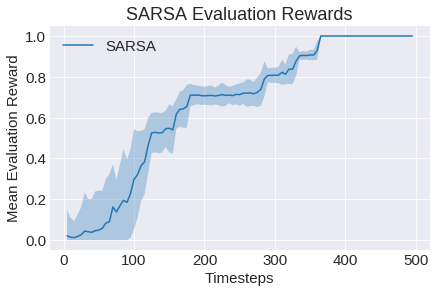

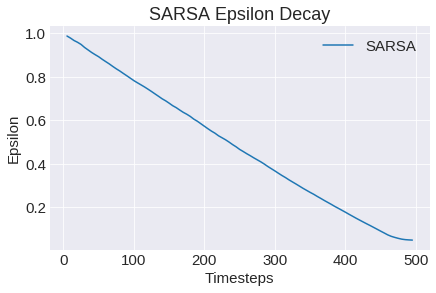

In [11]:
eval_reward_means = np.array(eval_reward_means).mean(axis=0)
eval_reward_stds = np.array(eval_reward_stds).mean(axis=0)
eval_epsilons = np.array(eval_epsilons).mean(axis=0)
plot_timesteps_shaded(
    eval_reward_means,
    eval_reward_stds,
    CONFIG["eval_freq"],
    "SARSA Evaluation Rewards",
    "Timesteps",
    "Mean Evaluation Reward",
    "SARSA",
)

plot_timesteps(
    eval_epsilons,
    CONFIG["eval_freq"],
    "SARSA Epsilon Decay",
    "Timesteps",
    "Epsilon",
    "SARSA",
)

plt.show()